<a href="https://colab.research.google.com/github/JV-Machado/Chess_Classification/blob/master/Chess_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [49]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [50]:
# import zipfile
# with zipfile.ZipFile('/content/drive/MyDrive/Chess_Project/Chess-image-dataset.zip', 'r') as zip_ref:
#     zip_ref.extractall('/content/drive/MyDrive/Chess_Project/Folder_Chess_Dataset')

**Organização dos dados**

In [51]:
# import glob
# from shutil import copyfile
# import os

# imgs = glob.glob("/content/drive/MyDrive/Chess_Project/Folder_Chess_Dataset/Chess-image-dataset/*/*")
# for img in imgs:
#   class_name = img.split("/")[-2][0:]
#   img_name = img.split("/")[-1][0:]
#   copyfile(img, f'/content/drive/MyDrive/Chess_Project/data/-{class_name}-{img_name}')

In [52]:
import pandas as pd
import glob

imgs_path = glob.glob('/content/drive/MyDrive/Chess_Project/data/*')
lista = []

for img_path in imgs_path:
  name = img_path.split('-')[-2][0:]
  # img = img_path.split('-')[-1][0:]
  lista.append([img_path, name])

In [53]:
df = pd.DataFrame(columns=["Image_Path", "Image_Class"], data=lista)
df

,Image_Path,Image_Class
0,/content/drive/MyDrive/Chess_Project/data/-Kni...,Knight
1,/content/drive/MyDrive/Chess_Project/data/-Kni...,Knight
2,/content/drive/MyDrive/Chess_Project/data/-Kni...,Knight
3,/content/drive/MyDrive/Chess_Project/data/-Kni...,Knight
4,/content/drive/MyDrive/Chess_Project/data/-Kni...,Knight
...,...,...
646,/content/drive/MyDrive/Chess_Project/data/-Kni...,Knight
647,/content/drive/MyDrive/Chess_Project/data/-Kni...,Knight
648,/content/drive/MyDrive/Chess_Project/data/-Kni...,Knight
649,/content/drive/MyDrive/Chess_Project/data/-Kni...,Knight


In [54]:
df['Image_Class'].value_counts()

Knight    174
Bishop    141
Rook      139
Queen     115
Pawn       82
Name: Image_Class, dtype: int64

In [55]:
categories = pd.factorize(df['Image_Class'])[1]
print(categories)
df['Image_Class'] = pd.factorize(df['Image_Class'])[0]
df

Index(['Knight', 'Pawn', 'Queen', 'Rook', 'Bishop'], dtype='object')


,Image_Path,Image_Class
0,/content/drive/MyDrive/Chess_Project/data/-Kni...,0
1,/content/drive/MyDrive/Chess_Project/data/-Kni...,0
2,/content/drive/MyDrive/Chess_Project/data/-Kni...,0
3,/content/drive/MyDrive/Chess_Project/data/-Kni...,0
4,/content/drive/MyDrive/Chess_Project/data/-Kni...,0
...,...,...
646,/content/drive/MyDrive/Chess_Project/data/-Kni...,0
647,/content/drive/MyDrive/Chess_Project/data/-Kni...,0
648,/content/drive/MyDrive/Chess_Project/data/-Kni...,0
649,/content/drive/MyDrive/Chess_Project/data/-Kni...,0


In [56]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import cv2
from google.colab.patches import cv2_imshow
import torch
from PIL import Image
from torch.utils.data import DataLoader,Dataset
import os

device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [57]:
import torchvision
from torchvision import transforms
from torchvision.datasets import ImageFolder
import os

preprocess = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.RandomRotation(15),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(
        [0.485, 0.456, 0.406], 
        [0.229, 0.224, 0.225])
])

In [58]:
class ImageDataset(Dataset):
    def __init__(self, df, transform = None):
        self.df = df
        self.transform = transform
        
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, index):
        image = Image.fromarray(cv2.cvtColor(cv2.imread(self.df.iloc[index,0]),cv2.COLOR_BGR2RGB))
        image=self.transform(image)
        y = torch.tensor(int(self.df.iloc[index,1]))

        return image, y

In [59]:
train_dataset = ImageDataset(df, transform = preprocess)

In [60]:
from torch.utils.data.dataloader import DataLoader
from torch.utils.data import random_split

In [61]:
validation_data_size = round(0.20*(len(train_dataset)))
train_data_size = len(train_dataset) - validation_data_size 

train_data, validation_data  = random_split(train_dataset, [train_data_size, validation_data_size])
print(f"Length of Train Data : {len(train_data)}")
print(f"Length of Validation Data : {len(validation_data)}")

Length of Train Data : 521
Length of Validation Data : 130


In [62]:
batch_size = 16

train_DL = DataLoader(train_data, batch_size, shuffle = True)
validation_DL = DataLoader(validation_data, batch_size, shuffle = True)

**Treinamento com CNN**

In [63]:
from torchvision import datasets, models, transforms
import torch.nn as nn
import torch.nn.functional as F
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

In [64]:
def train_loop(model, dataloader, loss_func, optimizer):
    model.train()
    cumloss = 0.0
    running_accuracy = 0.0

    for i, data in enumerate(dataloader):
        imgs, labels = data
    
        imgs, labels = imgs.to(device), labels.to(device)
    
        optimizer.zero_grad()

        pred = model(imgs)

        loss = loss_func(pred, labels)
        loss.backward()
        optimizer.step()

        cumloss += loss.item()
        
        ps = F.softmax(pred,-1)
        top_p, top_class = ps.topk(k = 1, dim = 1)
        equals = top_class == labels.view(*top_class.shape)

        accuracy = torch.mean(equals.type(torch.float))

        running_accuracy += accuracy

    return cumloss / len(dataloader), running_accuracy/len(dataloader)

def validate(model, dataloader, loss_func):
    model.eval()
    cumloss = 0.0
    running_accuracy_val = 0.0
    with torch.no_grad():
        for imgs, labels in dataloader:
            imgs, labels = imgs.to(device), labels.to(device)

            pred = model(imgs)
            loss = loss_func(pred, labels)
            cumloss += loss.item()

            ps = F.softmax(pred,-1)
            top_p, top_class = ps.topk(k = 1, dim = 1)
            equals = top_class == labels.view(*top_class.shape)

            accuracy_val = torch.mean(equals.type(torch.float))

            running_accuracy_val += accuracy_val

        return cumloss / len(dataloader), running_accuracy_val/len(dataloader)

In [65]:
model_ft = models.resnet50(weights="IMAGENET1K_V1")
model_ft = model_ft.to(device)
loss_func = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model_ft.parameters(), lr=0.001)

In [66]:
epochs = 25
conv_train_losses = []
conv_validation_losses = []
for t in range(epochs):
    train_loss, acc_train = train_loop(model_ft, train_DL, loss_func, optimizer)
    conv_train_losses.append(train_loss)
    print(f"\rEpoch: {t}; Train Loss: {train_loss} Accuracy train: {acc_train}")
    validation_loss, acc_validation = validate(model_ft, validation_DL, loss_func)
    conv_validation_losses.append(validation_loss)
    print(f"\rEpoch: {t}; Validate Loss: {validation_loss} Accuracy validation: {acc_validation}")

Epoch: 0; Train Loss: 7.443193941405325 Accuracy train: 0.02041245810687542
Epoch: 0; Validate Loss: 5.90006340874566 Accuracy validation: 0.0625
Epoch: 1; Train Loss: 3.9826478307897393 Accuracy train: 0.23127105832099915
Epoch: 1; Validate Loss: 2.8529087172614203 Accuracy validation: 0.3402777910232544
Epoch: 2; Train Loss: 2.05910832231695 Accuracy train: 0.5608165264129639
Epoch: 2; Validate Loss: 1.4794895648956299 Accuracy validation: 0.6388888955116272
Epoch: 3; Train Loss: 1.2686904759118052 Accuracy train: 0.6660353541374207
Epoch: 3; Validate Loss: 1.0014839304818048 Accuracy validation: 0.7291666865348816
Epoch: 4; Train Loss: 0.884462547121626 Accuracy train: 0.7546296715736389
Epoch: 4; Validate Loss: 0.8616585930188497 Accuracy validation: 0.756944477558136
Epoch: 5; Train Loss: 0.6699306540416948 Accuracy train: 0.8421717286109924
Epoch: 5; Validate Loss: 0.7772673434681363 Accuracy validation: 0.819444477558136
Epoch: 6; Train Loss: 0.5692007514563474 Accuracy train: 0

**Matriz de Confusão**

In [67]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import pandas as pd

y_pred = []
y_true = []
nb_classes = 5

confusion_matrix = torch.zeros(nb_classes, nb_classes)

for imgs, labels in validation_DL:
  imgs, labels = imgs.to(device), labels.to(device)

  pred = model_ft(imgs)

  _, preds = torch.max(pred, 1)
  for t, p in zip(labels.view(-1), preds.view(-1)):
    confusion_matrix[t.long(), p.long()] += 1

print(confusion_matrix)

tensor([[37.,  0.,  1.,  0.,  1.],
        [ 0., 17.,  0.,  0.,  1.],
        [ 0.,  0., 14.,  0.,  1.],
        [ 0.,  0.,  1., 28.,  0.],
        [ 0.,  4.,  0.,  0., 25.]])


Text(0.5, 23.52222222222222, 'Predicted label')

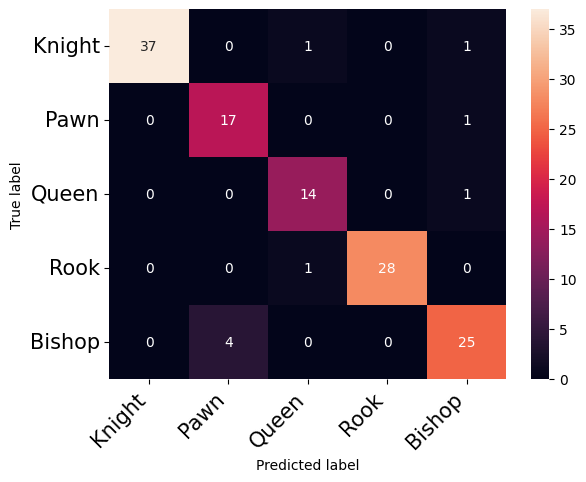

In [68]:
class_names = list(categories)
df_cm = pd.DataFrame(confusion_matrix, index=class_names, columns=class_names).astype(int)
heatmap = sns.heatmap(df_cm, annot=True, fmt="d")

heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right',fontsize=15)
heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right',fontsize=15)
plt.ylabel('True label')
plt.xlabel('Predicted label')